In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/1n")
dir = os.path.join(pickledir, "images_1n_wc_static_short")

print(dir)

def get_period(timeseries, dt):
    peaks = scipy.signal.find_peaks(timeseries, prominence=0.001)[0]
    periods = []
    if len(peaks) < 3:
        return 0.
    for i in range(2, len(peaks)-1):
        periods.append( (peaks[i] - peaks[i-1]) * dt)

    return np.mean(periods)

def plotspectrum(data, fmax=1., filename=None):

    for d in data:
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)]
        ps_plot[0] = 0.

        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

        plt.plot(fr, ps_plot)

    plt.xlim(-0.01,fmax)
    plt.ylim(0,1.1*np.amax(ps_plot))
    plt.tight_layout()

    if filename is not None:
        plt.savefig(os.path.join(dir, filename))
    
    plt.show()

    maxfreqind = np.where(ps_plot == max(ps_plot[1:]))
    print("freq of max = ", fr[maxfreqind])
    print("period of max = ", 1./fr[maxfreqind])

    return (1./fr[maxfreqind])[0]

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/1n/images_1n_wc_static_short


In [2]:
y0lim = [0, 0.6]
y1lim = [-2, 2]

def plot_control1(c, s, dur, dt, filename=None, title=None):
    fig, ax = plt.subplots(2,1, figsize=(16,6), sharex=True)
    time_array = np.linspace(0,dur,s.shape[2])

    cmax = np.amax(np.abs(c))
    y1lim = [-cmax* 1.1, cmax* 1.1]

    ax[0].plot(time_array, s[n,0,:], color="red", label="E")
    ax[0].plot(time_array, s[n,1,:], color="blue", label="I")
    ax[1].plot(time_array, c[n,0,:], color="red", label="E")
    ax[1].plot(time_array, c[n,1,:], color="blue", label="I")


    ax[0].legend(loc="lower right")
    ax[1].legend(loc="lower right")

    ax[0].set_xlim(0, dur)

    ax[0].set_ylim(y0lim)
    ax[1].set_ylim(y1lim)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")
    
    fig.align_ylabels([ax[:]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

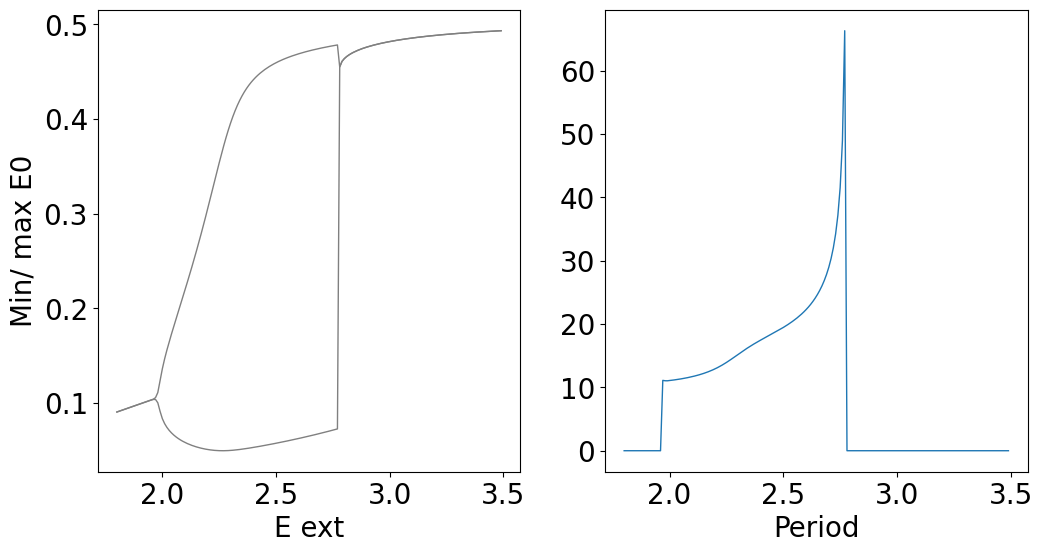

In [3]:
model = WCModel()
dt = 0.1

model.params['duration'] = 1e4
model.params.inh_ext_baseline = 1.

excrange = np.arange(1.8, 3.5, 0.01)

periods = np.zeros((len(excrange)))
maxx = np.zeros((len(excrange)))
minn = np.zeros((len(excrange)))

for ei, exc in enumerate(excrange):
    model.params.exc_ext_baseline = exc
    model.run()

    #plt.plot(model.exc[0,-3000:])
    #plt.plot(model.exc[1,-3000:])
    #plt.show()

    per0 = get_period(-model.exc[0,10000:], dt)
    periods[ei] = per0
    maxx[ei] = np.amax(model.exc[0,10000:])
    minn[ei] = np.amin(model.exc[0,10000:])


fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(excrange, maxx, color="gray")
ax[0].plot(excrange, minn, color="gray")
ax[1].plot(excrange, periods)

ax[0].set_xlabel("E ext")
ax[1].set_xlabel("E ext")

ax[0].set_ylabel("Min/ max E0")
ax[1].set_xlabel("Period")

plt.savefig(os.path.join(dir, "amp_period.png"))
plt.show()

In [4]:
p_names = ["D-exp", "D-osc", "U-exp", "U-osc", "Bi-exp", "Bi-osc"]
coords = [[1., 1.5], [1.95, 1.], [3., 1.], [2.2, 0.4], [2.2, 2.1], [2.4, 1.6]]

NameError: name 'data' is not defined

D-osc


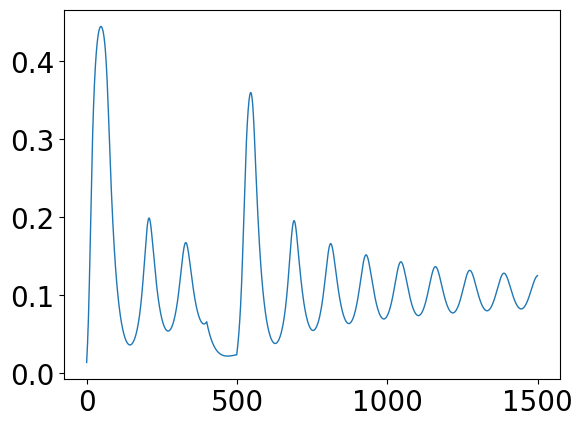

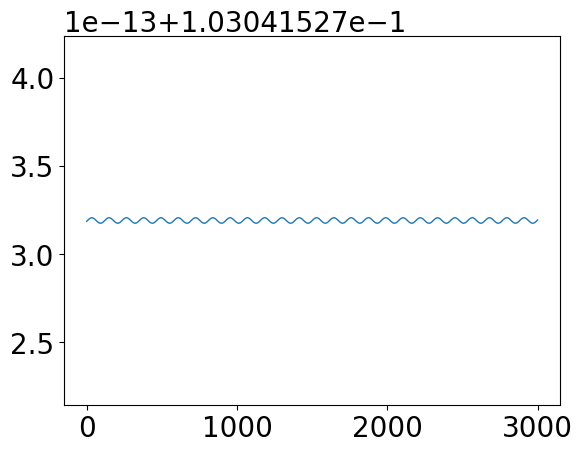

11.229411764705885


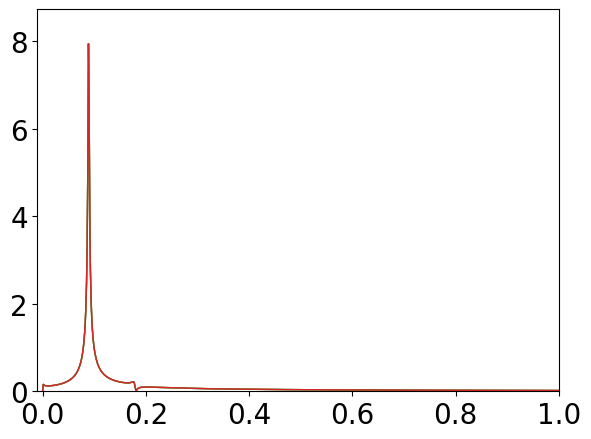

freq of max =  [0.08877219]
period of max =  [11.26478873]


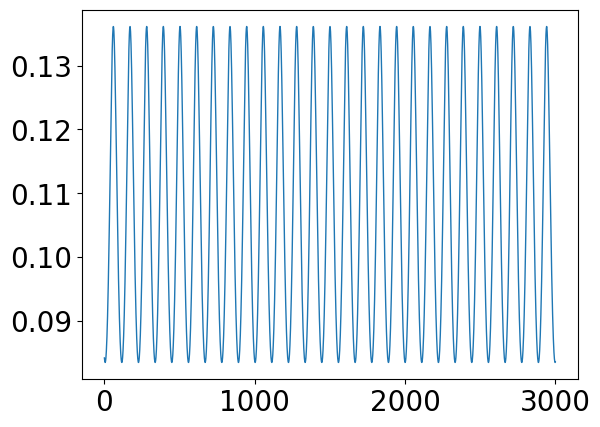

amplitude of oscillation =  0.05263734997106177


In [5]:
if True:
    data = dict()

    for i in range(len(p_names)):
        p = p_names[i]
        data[p] = dict()
        data[p]["coordinates"] = coords[i]
        data[p]["target_period"] = 20.
        data[p]["delay"] = 9.5

        data[p]["control"] = [None, None]
        data[p]["state"] = [None, None]
        data[p]["init_state"] = None
        data[p]["weight"] = [5. * 1e-5, 5. * 1e-4]
        data[p]["dur/per"] = [340., 10]

duration = 1e4
dt = 0.1

test_input_plus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_plus[:,400:500] = 1.

test_input_minus = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_minus[:,400:500] = -1.

for pi in range(len(p_names)):

    if pi not in [1]: continue

    print(p_names[pi])

    model = WCModel()

    model.params['duration'] = duration
    model.params.exc_ext_baseline = data[p_names[pi]]["coordinates"][0]
    model.params.inh_ext_baseline = data[p_names[pi]]["coordinates"][1]
    model.params["exc_ext"] = test_input_minus

    model.run()
    nmaxdelay = model.getMaxDelay()

    einit = np.zeros((1, nmaxdelay+1))
    iinit = np.zeros((1, nmaxdelay+1))

    for n in range(1):
        einit[n,:] = model.exc[n,-nmaxdelay-1:]
        iinit[n,:] = model.inh[n,-nmaxdelay-1:]

    data[p_names[pi]]["init_state"] = [einit, iinit]

    if "osc" in p_names[pi]:
        plt.plot(model.exc[0,0:1500])
        plt.show()
        plt.plot(model.exc[0,-3000:])
        plt.show()

        i0, i1 = 2000, 10000

        per0 = get_period(-model.exc[0,i0:i1], dt)
        data[p_names[pi]]["target_period"] = per0

        print(per0)

        plotspectrum( [model.exc[0,i0:i1], model.exc[0,i0:i1], model.exc[0,i0:i1], model.exc[0,i0:i1]])

        model.params.exc_ext_baseline += 0.05
        model.run()
        #per0 = get_period(-model.exc[0,3000:], dt)
        #per1 = get_period(-model.exc[1,3000:], dt)
        #data[p_names[pi]]["target_period"] = np.mean([per0, per1])

        #print(per0, per1)

        plt.plot(model.exc[0,-3000:])
        plt.show()

        print("amplitude of oscillation = ", np.amax(model.exc[0,-3000:]) - np.amin(model.exc[0,-3000:]))

In [6]:
controlmat = np.ones((1,2))

costmat = np.zeros((1, 2))
costmat[:,0] = 1.

it = 50
maxstr = 5

pr = np.arange(0,1001,100)
testd = 1000.

zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*1))

In [7]:
def optimize_model(model, exprange):
    for l in range(2):
        for k in exprange:
            model.zero_step_encountered = False
            model.step = 10**(k)
            model.optimize(it)
        model.control_matrix = controlmat
    model.zero_step_encountered = False

    return

In [8]:
data["D-osc"]["weight"] = [1. * 1e-3, 1. * 1e-2]

Point  D-osc
target period, max delay =  11.226470588235296 0
duration =  340.0
w2 =  0.001
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.00013139575515123364
Final cost : 0.00013139575515123364


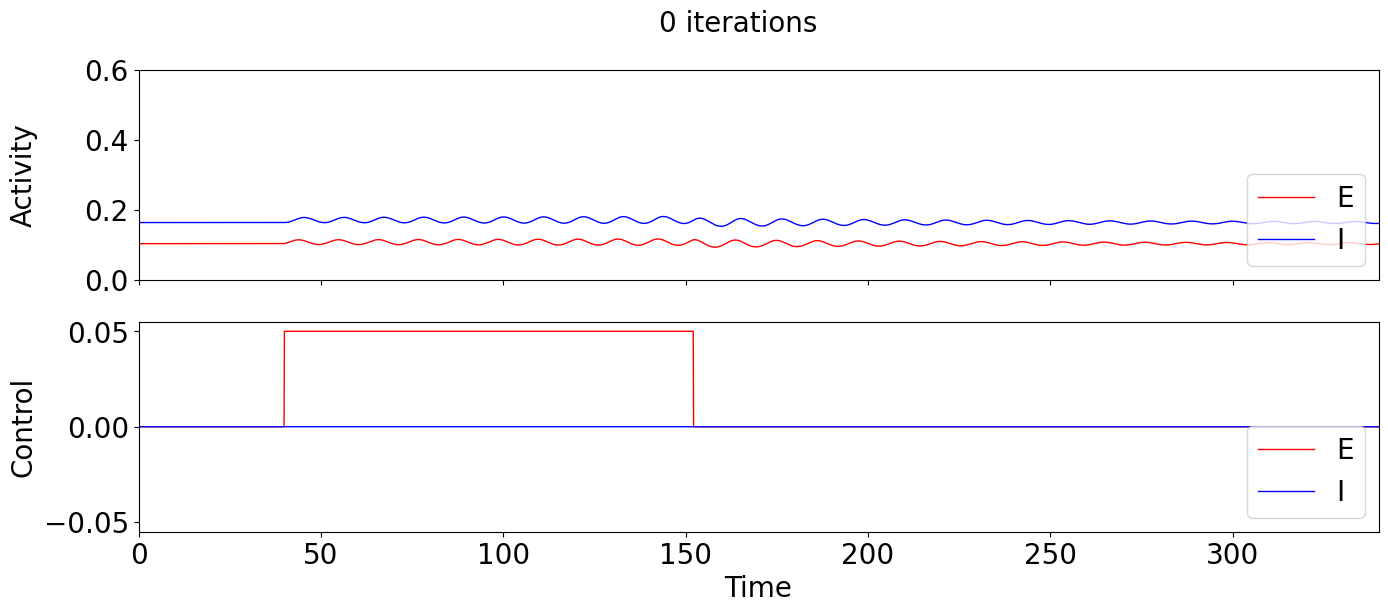

Compute control for a deterministic system
Cost in iteration 0: 0.00013139575515123364
Final cost : 9.187045122624227e-05


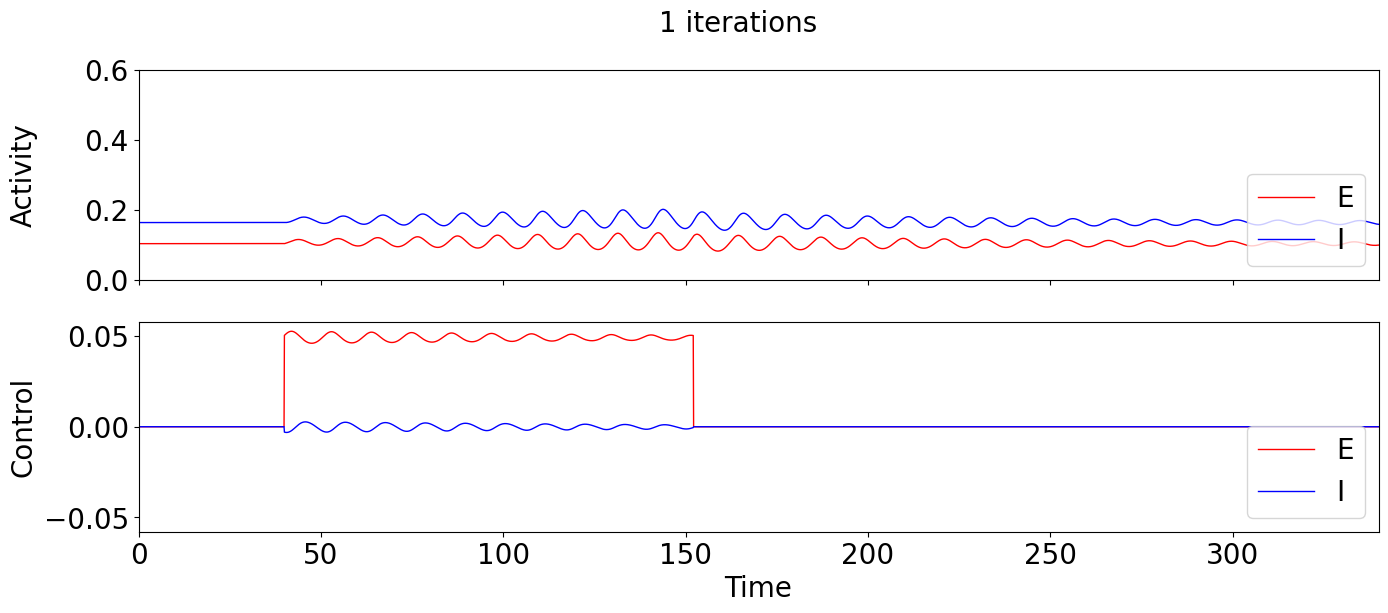

Compute control for a deterministic system
Cost in iteration 0: 9.187045122624227e-05
Final cost : -4.401495308411154e-05
Compute control for a deterministic system
Cost in iteration 0: -4.401495308411154e-05
Final cost : -8.836166986563569e-05


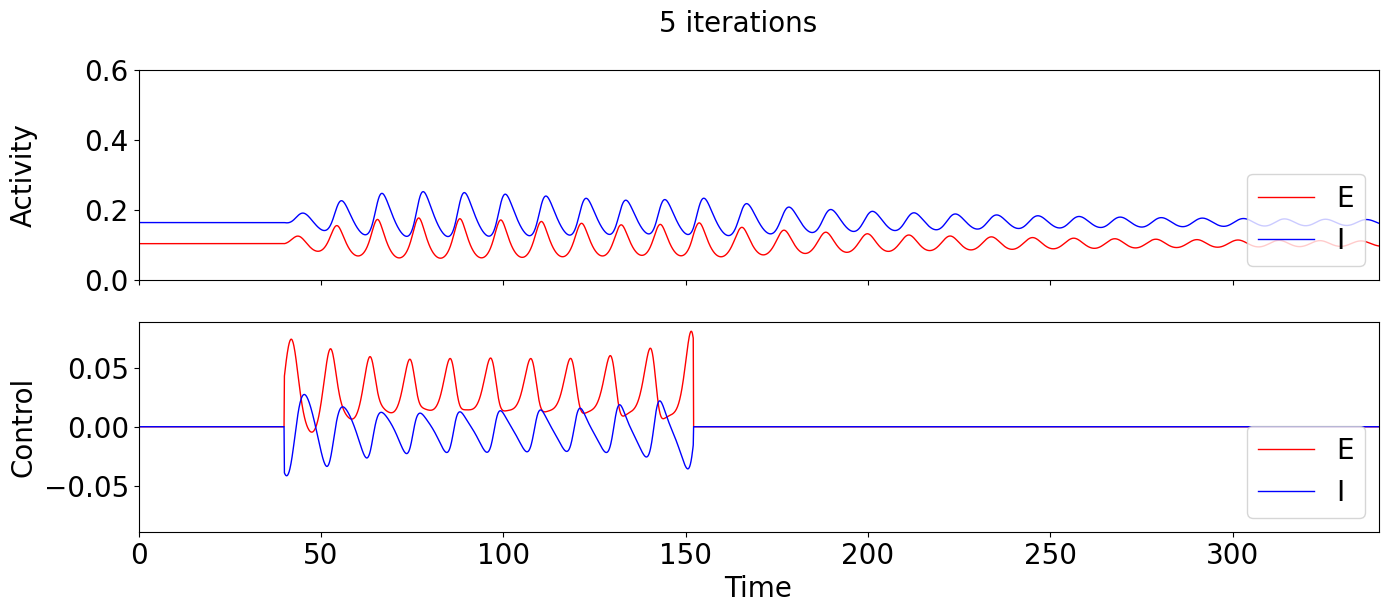

Compute control for a deterministic system
Cost in iteration 0: -8.836166986563569e-05
Final cost : -0.00011484146456756409
Compute control for a deterministic system
Cost in iteration 0: -0.00011484146456756409
Final cost : -0.00011709861897102845


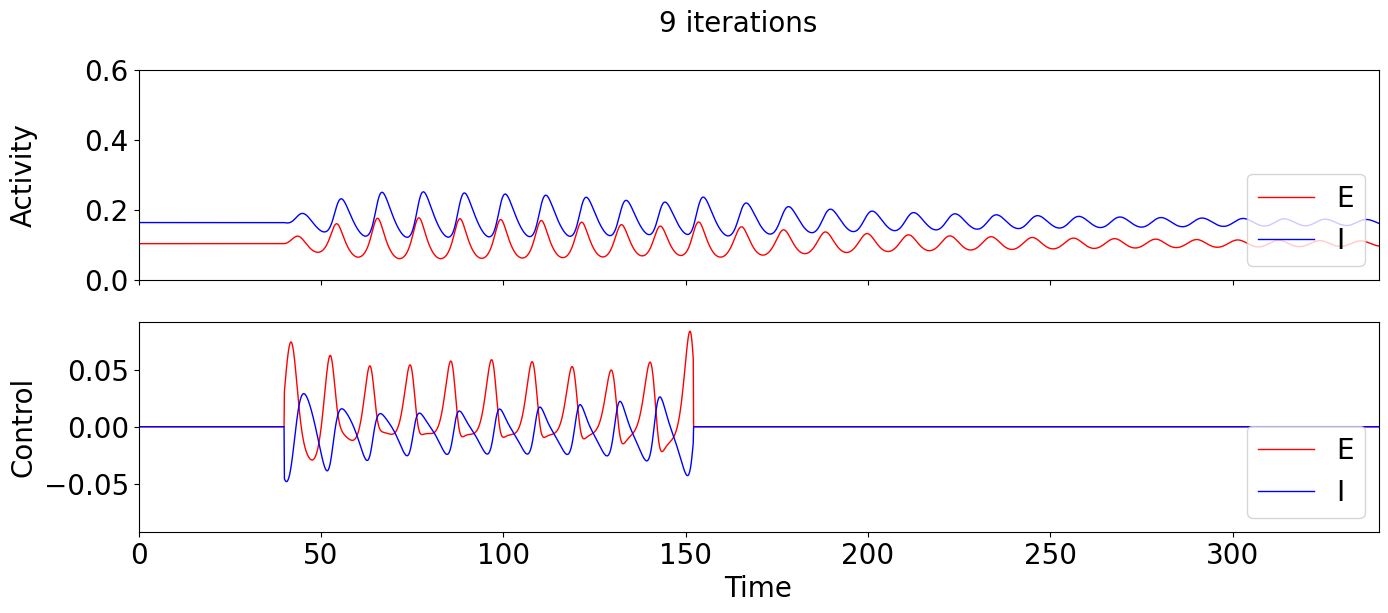

Compute control for a deterministic system
Cost in iteration 0: -0.00011709861897102845
Final cost : -0.00011797248526432211
Compute control for a deterministic system
Cost in iteration 0: -0.00011797248526432211
Final cost : -0.00011835584605600417


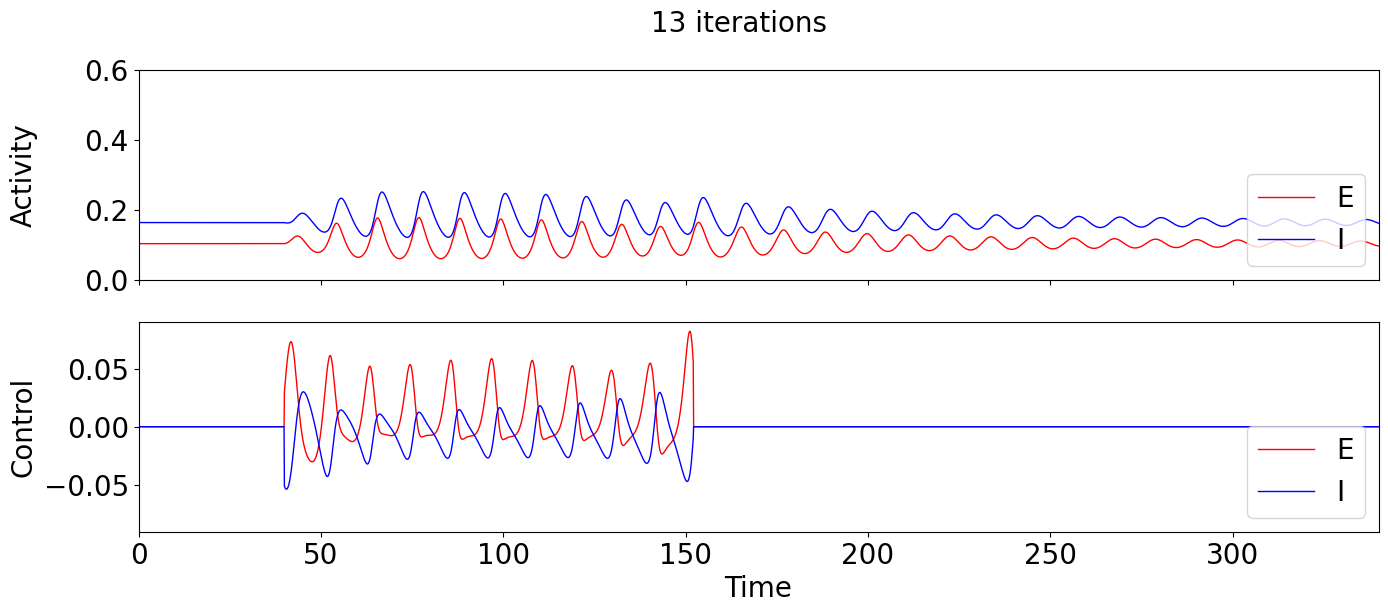

Compute control for a deterministic system
Cost in iteration 0: -0.00011835584605600417
Final cost : -0.00011887965677444054
Compute control for a deterministic system
Cost in iteration 0: -0.00011887965677444054
Final cost : -0.0001190811282890477


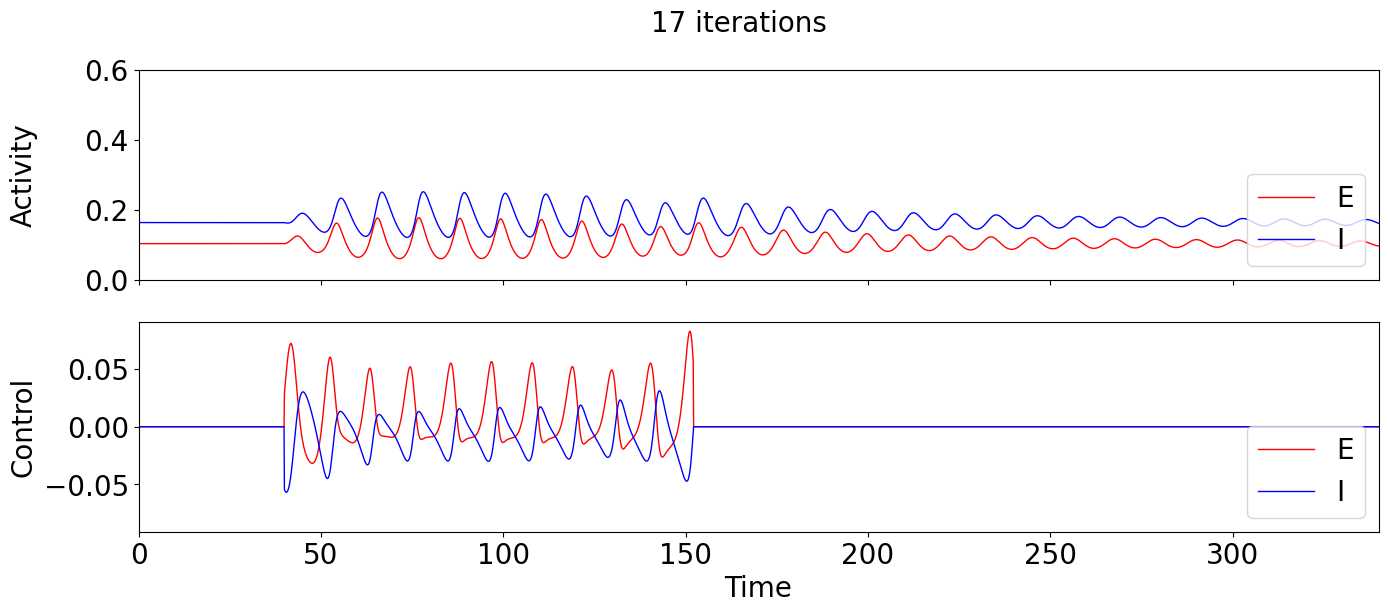

Compute control for a deterministic system
Cost in iteration 0: -0.0001190811282890477
Final cost : -0.00011910921643825514
Compute control for a deterministic system
Cost in iteration 0: -0.00011910921643825514
Final cost : -0.00011913487970186408


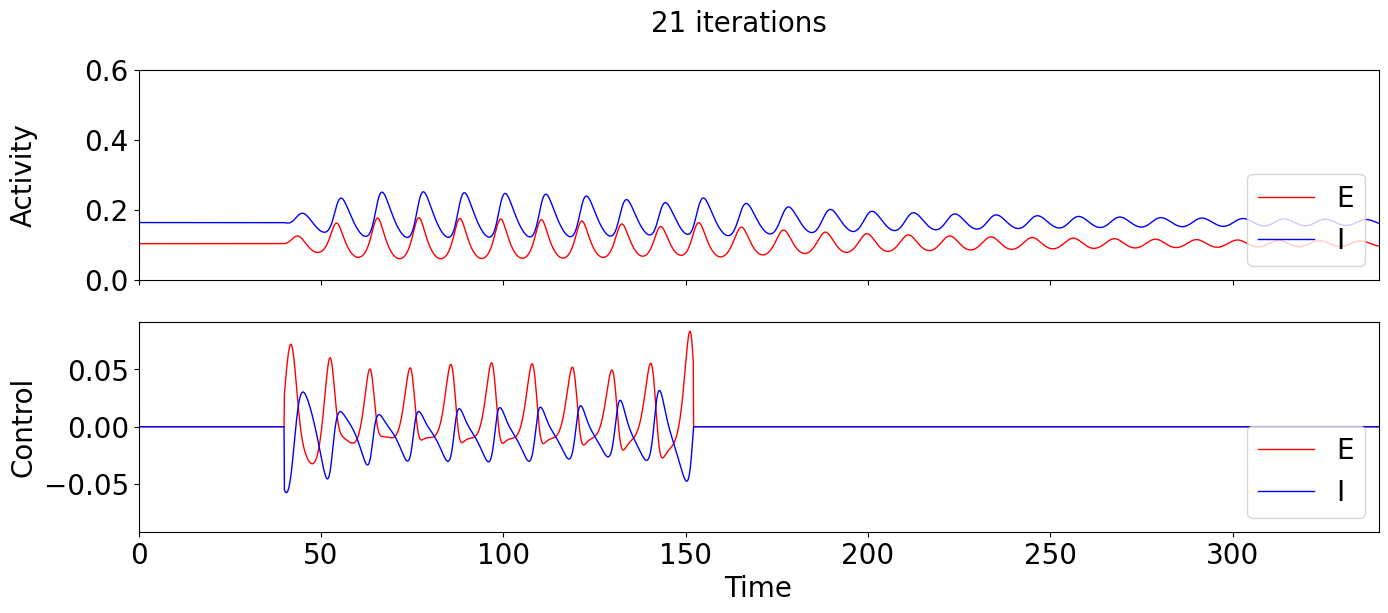

Compute control for a deterministic system
Cost in iteration 0: -0.00011913487970186408
Final cost : -0.00011914751269051927
w2 =  0.01


In [193]:
it = 100

for pi in range(len(p_names)):
    p = p_names[pi]

    if pi not in [1]: continue

    print("Point ", p)
      
    target_period = data[p]["target_period"]

    model = WCModel()
    nmaxdelay = model.getMaxDelay()
    print("target period, max delay = ", target_period, nmaxdelay)

    model.params["exc_ext_baseline"] =  data[p]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data[p]["coordinates"][1]
        
    model.params.duration = data[p]["dur/per"][0]
    print("duration = ", model.params.duration)

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*1))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]

    model.params["exc_init"] = data[p]["init_state"][0]
    model.params["inh_init"] = data[p]["init_state"][1]

    model.run()
    
    int0 = 400
    int1 = int0 + int(data[p]["dur/per"][1]*target_period/dt)

    for wi, w2 in enumerate(data[p]["weight"]):

        print("w2 = ",w2)

        #if wi not in [0]: continue

        for factor in [1]:
        #for factor in np.random.rand(10):

            model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), control_interval=(int0, int1), 
                                          cost_matrix=costmat, control_matrix=controlmat, )
            model_controlled.channelwise_optimization = True
            model_controlled.weights["w_p"] = 0.
            model_controlled.weights["w_2"] = w2
            model_controlled.weights["w_f_sync"] = 1.

            model_controlled.maximum_control_strength = maxstr

            if False:
                if type(data[p]["control"][wi]) != type(None):
                    model_controlled.control = data[p]["control"][wi].copy()
                    model_controlled.update_input()

            input_control = zero_control.copy()
            input_control[:,0,int0:int1] = 0.05
            model_controlled.control = input_control
            model_controlled.update_input()

            model_controlled.grad_method = 0
            model_controlled.channelwise_optimization = True
            
            model_controlled.optimize(0)
            plot_control1(model_controlled.control, model_controlled.get_xs(), data[p]["dur/per"][0], dt, filename=os.path.join(dir, "static_init_0.png"), title="0 iterations")

            for k in range(6):
                model_controlled.optimize(1)
                plot_control1(model_controlled.control, model_controlled.get_xs(), data[p]["dur/per"][0], dt, filename=os.path.join(dir, "static_init_"+str(k+1)+".png"), title=str( (k+1)*4-3) + " iterations")
                model_controlled.optimize(3)

            for l in range(0):
                for k in np.arange(-10., 10., 2.):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10**(k)
                    model_controlled.optimize(it)

            model_controlled.grad_method = 1

            for l in range(0):
                for k in np.arange(-8., 8., 2.):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10**(k)
                    model_controlled.optimize(10)

            #data[p]["control"][wi] = model_controlled.control.copy()
            #data[p]["state"][wi] = model_controlled.get_xs()

    #plot_control(data[p], data[p]["dur/per"][0], dt, 0)
    #plot_control(data[p], data[p]["dur/per"][0], dt, 1)

#with open(os.path.join(pickledir, '2n_wc_static_short.pickle'), 'wb') as f:
#    pickle.dump(data, f)

In [11]:
from numba.typed import Dict
from numba.core import types

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

period_range = [9., 9.5, 10., 10.5, 11., 11.1, 11.2265, 11.3, 11.5, 12., 12.5, 13., 13.5, 14.]

c0 = [[None for x0 in range(len(period_range))] for x1 in range(3)]
s0 = [[None for x0 in range(len(period_range))] for x1 in range(3)]

[9.0, 9.5, 10.0, 10.5, 11.0, 11.1, 11.2265, 11.3, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0]


In [12]:
print(len(period_range))
it = 1000

14


In [17]:
for fi, target_period in enumerate(period_range):

    #if fi not in [0,1,2,3]: continue

    model = WCModel()
    model.params["exc_ext_baseline"] =  data["D-osc"]["coordinates"][0]
    model.params["inh_ext_baseline"] =  data["D-osc"]["coordinates"][1]

    zero_input0 = ZeroInput().generate_input(duration=model.params.duration+model.params.dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*1))
    model.params["exc_ext"] = zero_control[:,0,:]
    model.params["inh_ext"] = zero_control[:,1,:]

    model.params["exc_init"] = data["D-osc"]["init_state"][0]
    model.params["inh_init"] = data["D-osc"]["init_state"][1]

    model.run()
    
    int0 = 200
    int1 = int0 + int(data["D-osc"]["dur/per"][1]*target_period/dt)
    model.params.duration = int1 * dt + 10

    for wi, w2 in enumerate([1e-3, 0.2 * 1e-3, 0.04 * 1e-3]):

        #if wi not in [1]: continue

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,int1), control_interval=(int0, int1), 
                                        cost_matrix=costmat, control_matrix=controlmat, )
        model_controlled.channelwise_optimization = True
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = w2
        model_controlled.weights["w_f_sync"] = 1.

        model_controlled.maximum_control_strength = maxstr

        if True:
            if type(c0[wi][fi]) != type(None):
                model_controlled.control = c0[wi][fi].copy()
                model_controlled.update_input()

                if False and cost_functions.control_strength_cost(c0[wi][fi], weights, dt) > 1.:
                    print("SOLUTION FOUND, CONTINUE")
                    continue

        model_controlled.grad_method = 0
        model_controlled.channelwise_optimization = True

        for l in range(0):
            for k in np.arange(6., 24., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        for j in range(1):
            model_controlled.grad_method = 0
            for l in range(1):
                for k in np.arange(-10., 10., 2.):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10**(k)
                    model_controlled.optimize(it)

            model_controlled.grad_method = 1

            for l in range(1):
                for k in np.arange(-8., 8., 2.):
                    model_controlled.zero_step_encountered = False
                    model_controlled.step = 10**(k)
                    model_controlled.optimize(10)

        c0[wi][fi] = model_controlled.control.copy()
        s0[wi][fi] = model_controlled.get_xs()

        print("------------------------------ period, energy input = ", target_period, cost_functions.control_strength_cost(c0[wi][fi], weights, dt))
        #plot_control1(c0[wi][fi], s0[wi][fi], model_controlled.model.params.duration, dt)

    with open(os.path.join(pickledir, '1n_wc_static_short.pickle'), 'wb') as f:
        pickle.dump([c0,s0], f)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.0001229084320143989
Converged in iteration 1 with cost -0.0001229084320143989
Final cost : -0.0001229084320143989
Compute control for a deterministic system
Cost in iteration 0: -0.0001229084320143989
Converged in iteration 1 with cost -0.0001229084320143989
Final cost : -0.0001229084320143989
Compute control for a deterministic system
Cost in iteration 0: -0.0001229084320143989
Converged in iteration 2 with cost -0.0001229084320143989
Final cost : -0.0001229084320143989
Compute control for a deterministic system
Cost in iteration 0: -0.0001229084320143989
Converged in iteration 2 with cost -0.0001229084320143989
Final cost : -0.0001229084320143989
Compute control for a deterministic system
Cost in iteration 0: -0.0001229084320143989
Converged in iteration 2 with cost -0.0001229084320143989
Final cost : -0.0001229084320143989
Compute control for a deterministic system
Cost 

In [ ]:
1.7715723689246876
1.7668754699459999
1.7321061601654901

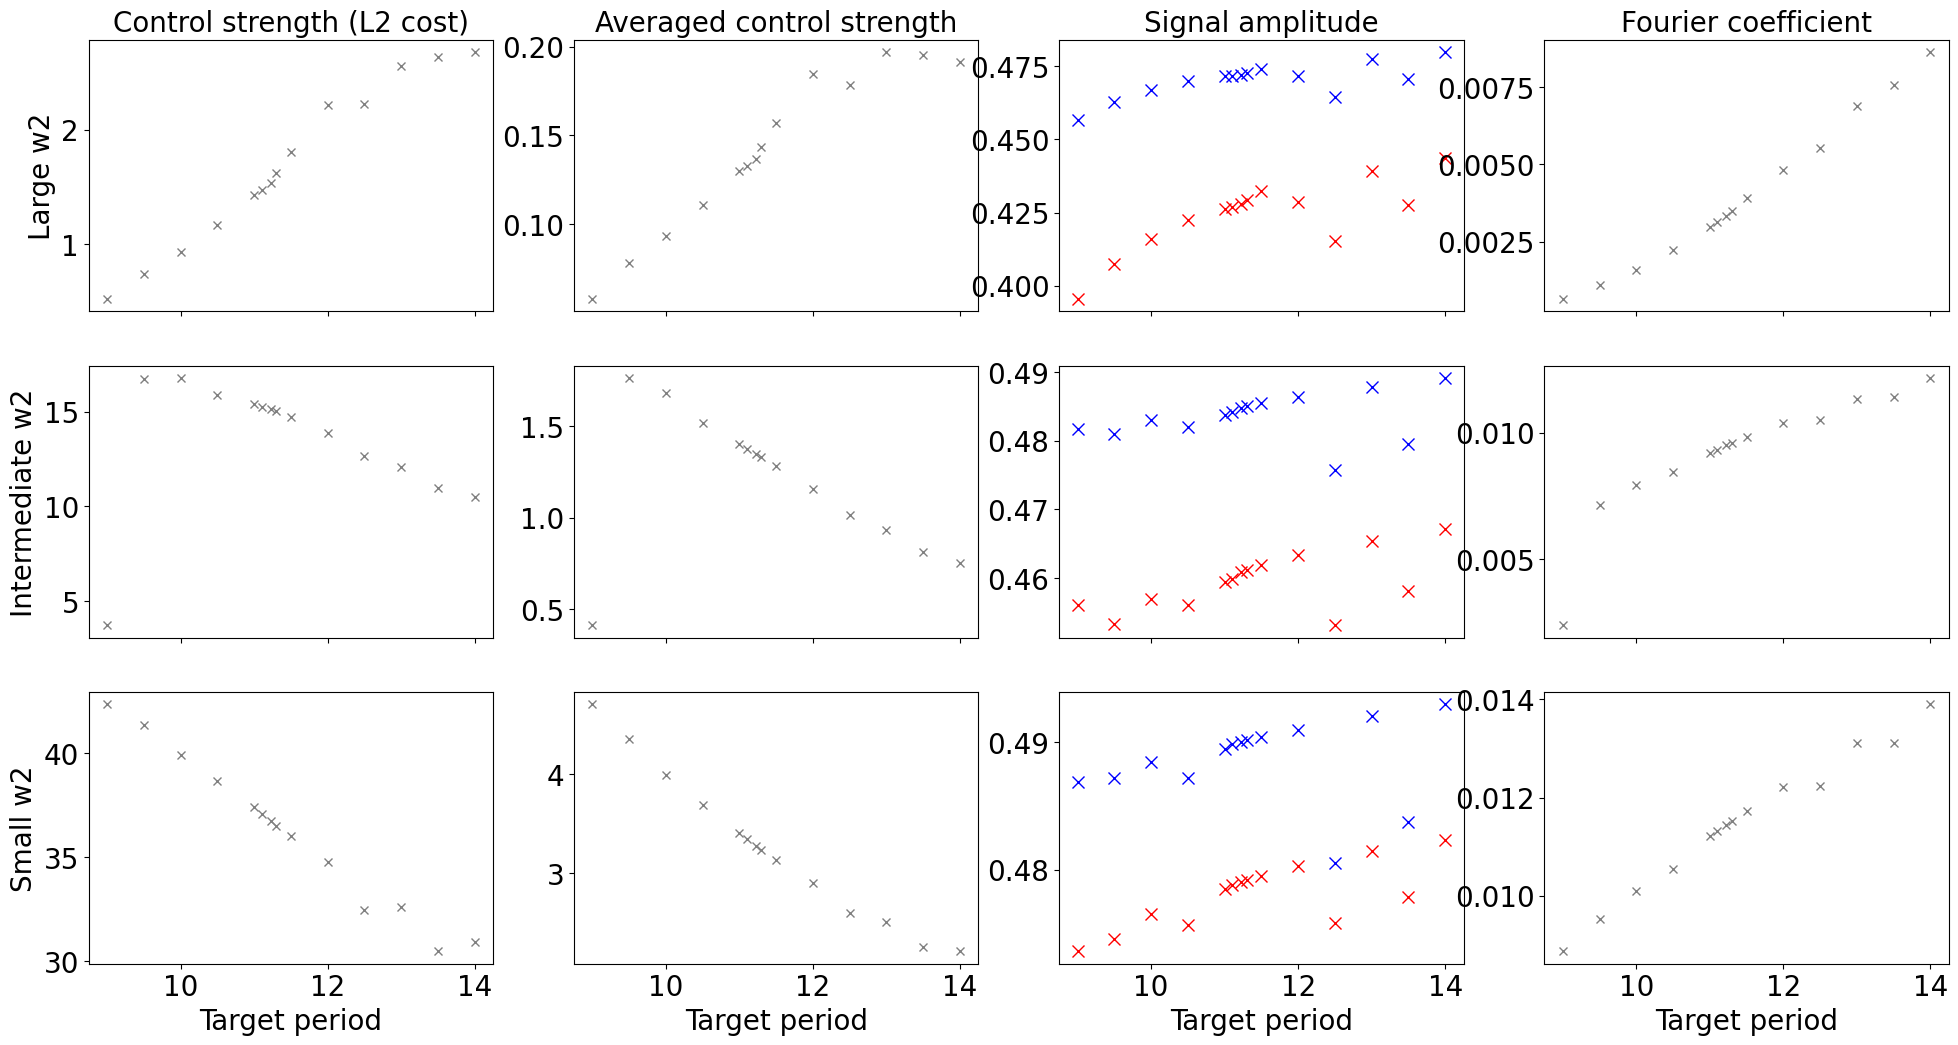

In [16]:
fig, ax = plt.subplots(3,4, figsize=(24,12), sharex=True)

col = "gray"
ms = 8

for wi in range(3):

    #if wi not in [0,1]: continue

    for fi, target_period in enumerate(period_range):

        int0 = 200
        int1 = int0 + int(data["D-osc"]["dur/per"][1]*target_period/dt)

        control_strength = cost_functions.control_strength_cost(c0[wi][fi], weights, dt)
        av_control_strength = control_strength / target_period
        osc_amp = [np.amax(s0[wi][fi][:,0,:]), np.amax(s0[wi][fi][:,1,:])]
        fourier_cost = - sum(cost_functions.fourier_cost_sync(s0[wi][fi], dt, target_period, costmat, [int0,int1]))

        ax[wi,0].plot(target_period, control_strength, marker="x",color=col)
        ax[wi,1].plot(target_period, av_control_strength, marker="x",color=col)
        ax[wi,2].plot(target_period, osc_amp[0], marker="x",color="red", markersize=ms)
        ax[wi,2].plot(target_period, osc_amp[1], marker="x",color="blue", markersize=ms)
        ax[wi,3].plot(target_period, fourier_cost, marker="x",color=col)

ax[0,0].set_title("Control strength (L2 cost)")
ax[0,1].set_title("Averaged control strength")
ax[0,2].set_title("Signal amplitude")
ax[0,3].set_title("Fourier coefficient")

ax[2,0].set_ylabel("Small w2")
ax[1,0].set_ylabel("Intermediate w2")
ax[0,0].set_ylabel("Large w2")

ax[-1,0].set_xlabel("Target period")
ax[-1,1].set_xlabel("Target period")
ax[-1,2].set_xlabel("Target period")
ax[-1,3].set_xlabel("Target period")

plt.show()
fig.tight_layout()

fig.savefig(os.path.join(dir, "freq_range.png"))

In [ ]:
with open(os.path.join(pickledir, '1n_wc_static_short.pickle'), 'wb') as f:
    pickle.dump([c0,s0], f)

In [13]:
with open(os.path.join(pickledir, '1n_wc_static_short.pickle'), 'rb') as f:
    res_read = pickle.load(f)

[c0,s0] = res_read.copy()